In [1]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
energy = pd.read_csv("Data_for_UCI_named.csv")
energy.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [3]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stab    10000 non-null  float64
 13  stabf   10000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [4]:
energy['stabf'].value_counts()

unstable    6380
stable      3620
Name: stabf, dtype: int64

In [5]:
stable_energy = energy[energy.stabf == "stable"]
unstable_energy = energy[energy.stabf == "unstable"].sample(5000)
energy_data = stable_energy.append(unstable_energy)

In [6]:
import sklearn.utils
energy_data = sklearn.utils.shuffle(energy_data)
energy_data = energy_data.reset_index(drop=True)
energy_data.shape

(8620, 14)

In [7]:
energy_data.stabf.value_counts()

unstable    5000
stable      3620
Name: stabf, dtype: int64

In [8]:
# more processing
energy_data = energy_data.drop(columns=['stab'])

In [9]:
X = energy_data.drop(columns='stabf')
y = energy_data['stabf']

In [10]:
# split the data into training and testing set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
y_train.value_counts()

unstable    4005
stable      2891
Name: stabf, dtype: int64

In [11]:
# The samples are still not balanced, I will be balancing it with SMOTE
import imblearn
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=1)
x_train_balanced, y_balanced = smote.fit_resample(x_train, y_train)
y_balanced.value_counts()

unstable    4005
stable      4005
Name: stabf, dtype: int64

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [13]:
normalised_train_energy = scaler.fit_transform(x_train_balanced)
normalised_train_energy = pd.DataFrame(normalised_train_energy)
normalised_train_energy = x_train_balanced

In [14]:
x_test = x_test.reset_index(drop=True)
normalised_test_energy = scaler.transform(x_test)
normalised_test_energy = pd.DataFrame(normalised_test_energy)
normalised_test_energy = x_test

In [15]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
rand_clf = RandomForestClassifier(max_depth=2, random_state=1)
rand_clf.fit(x_train_balanced, y_balanced)

RandomForestClassifier(max_depth=2, random_state=1)

In [16]:
rand_pred = rand_clf.predict(x_test)
rand_pred

array(['stable', 'unstable', 'stable', ..., 'unstable', 'unstable',
       'stable'], dtype=object)

In [17]:
#confusion matrix
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix
cnf_mat = confusion_matrix(y_true=y_test, y_pred=rand_pred, labels=['stable', 'unstable'])
cnf_mat

#Preview the confusion matrix
good_cnf = pd.DataFrame(cnf_mat, columns=['Actual- Positive', 'Actual- Negative'], 
                        index=['Predicted- Positive', 'Predicted- Negative'])
good_cnf

,Actual- Positive,Actual- Negative
Predicted- Positive,595,134
Predicted- Negative,171,824


In [18]:
# running a cross validation
from sklearn.model_selection import cross_val_score 
scores = cross_val_score(rand_clf, x_train_balanced, y_balanced, cv= 5 , scoring= 'accuracy', n_jobs=-1, verbose=1) 
scores 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.9s finished


array([0.80586767, 0.81398252, 0.81772784, 0.83083645, 0.83583021])

In [19]:
RandomForestClassifier().__dict__

{'estimator': DecisionTreeClassifier(),
 'n_estimators': 100,
 'estimator_params': ('criterion',
  'max_depth',
  'min_samples_split',
  'min_samples_leaf',
  'min_weight_fraction_leaf',
  'max_features',
  'max_leaf_nodes',
  'min_impurity_decrease',
  'random_state',
  'ccp_alpha'),
 'base_estimator': 'deprecated',
 'bootstrap': True,
 'oob_score': False,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False,
 'class_weight': None,
 'max_samples': None,
 'criterion': 'gini',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'ccp_alpha': 0.0}

In [20]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, rand_pred))

              precision    recall  f1-score   support

      stable       0.78      0.82      0.80       729
    unstable       0.86      0.83      0.84       995

    accuracy                           0.82      1724
   macro avg       0.82      0.82      0.82      1724
weighted avg       0.82      0.82      0.82      1724



In [21]:
# Extra Trees Classifier model
xtclf = ExtraTreesClassifier(n_estimators=100, random_state=1, verbose=1)
xtclf.fit(x_train_balanced, y_balanced)
xtclf_pred = xtclf.predict(x_test)
xtclf_pred

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array(['unstable', 'unstable', 'stable', ..., 'unstable', 'stable',
       'stable'], dtype=object)

In [22]:
# running a cross validation
from sklearn.model_selection import cross_val_score 
scores = cross_val_score(xtclf, normalised_train_energy, y_balanced, cv= 5 , scoring= 'accuracy', n_jobs=-1, verbose=1) 
scores 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


array([0.92759051, 0.92759051, 0.92821473, 0.94694132, 0.93820225])

In [23]:
ExtraTreesClassifier().__dict__

{'estimator': ExtraTreeClassifier(),
 'n_estimators': 100,
 'estimator_params': ('criterion',
  'max_depth',
  'min_samples_split',
  'min_samples_leaf',
  'min_weight_fraction_leaf',
  'max_features',
  'max_leaf_nodes',
  'min_impurity_decrease',
  'random_state',
  'ccp_alpha'),
 'base_estimator': 'deprecated',
 'bootstrap': False,
 'oob_score': False,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False,
 'class_weight': None,
 'max_samples': None,
 'criterion': 'gini',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'ccp_alpha': 0.0}

In [24]:
#confusion matrix
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix
cnf_mat = confusion_matrix(y_true=y_test, y_pred=xtclf_pred, labels=['stable', 'unstable'])
cnf_mat

#Preview the confusion matrix
good_cnf = pd.DataFrame(cnf_mat, columns=['Actual- Positive', 'Actual- Negative'], 
                        index=['Predicted- Positive', 'Predicted- Negative'])
good_cnf

,Actual- Positive,Actual- Negative
Predicted- Positive,677,52
Predicted- Negative,62,933


In [25]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, xtclf_pred))

              precision    recall  f1-score   support

      stable       0.92      0.93      0.92       729
    unstable       0.95      0.94      0.94       995

    accuracy                           0.93      1724
   macro avg       0.93      0.93      0.93      1724
weighted avg       0.93      0.93      0.93      1724



In [26]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()
lgb.fit(x_train_balanced, y_balanced)
lgb_predict = lgb.predict(x_test)
lgb_predict

array(['unstable', 'unstable', 'stable', ..., 'unstable', 'unstable',
       'stable'], dtype=object)

In [27]:
#confusion matrix
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix
cnf_mat = confusion_matrix(y_true=y_test, y_pred=lgb_predict, labels=['stable', 'unstable'])
cnf_mat

#Preview the confusion matrix
good_cnf = pd.DataFrame(cnf_mat, columns=['Actual- Positive', 'Actual- Negative'], 
                        index=['Predicted- Positive', 'Predicted- Negative'])
good_cnf

,Actual- Positive,Actual- Negative
Predicted- Positive,691,38
Predicted- Negative,42,953


In [28]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, lgb_predict))

              precision    recall  f1-score   support

      stable       0.94      0.95      0.95       729
    unstable       0.96      0.96      0.96       995

    accuracy                           0.95      1724
   macro avg       0.95      0.95      0.95      1724
weighted avg       0.95      0.95      0.95      1724



In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_balanced = le.fit_transform(y_balanced)
y_test = le.fit_transform(y_test)

In [30]:
# xgboost from random forest
from xgboost import XGBRFClassifier
xgb = XGBRFClassifier()
xgb.fit(normalised_train_energy, y_balanced)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None,
                reg_alpha=None, ...)

In [31]:
xgb_predict = xgb.predict(x_test)
print('Predicted Class: ', xgb_predict)

Predicted Class:  [0 1 0 ... 1 1 0]


In [32]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_predict))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       729
           1       0.89      0.88      0.89       995

    accuracy                           0.87      1724
   macro avg       0.87      0.87      0.87      1724
weighted avg       0.87      0.87      0.87      1724



In [33]:
# xgboost from gradient boosting
from xgboost import XGBClassifier
xgboost = XGBClassifier()
xgboost.fit(normalised_train_energy, y_balanced)

# make predictions
xgboost_predict = xgboost.predict(x_test)
print('Predicted Class: ', xgboost_predict)

Predicted Class:  [1 1 0 ... 1 1 0]


In [34]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, xgboost_predict))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       729
           1       0.96      0.95      0.95       995

    accuracy                           0.94      1724
   macro avg       0.94      0.94      0.94      1724
weighted avg       0.95      0.94      0.94      1724



In [35]:
#confusion matrix
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix
cnf_mat = confusion_matrix(y_true=y_test, y_pred=xgboost_predict)
cnf_mat

#Preview the confusion matrix
good_cnf = pd.DataFrame(cnf_mat, columns=['Actual- Positive', 'Actual- Negative'], 
                        index=['Predicted- Positive', 'Predicted- Negative'])
good_cnf

,Actual- Positive,Actual- Negative
Predicted- Positive,686,43
Predicted- Negative,52,943


In [36]:
# to know which of the features that has the most importance or affecting the model more in making predictions
xgboost.feature_importances_ 

array([0.13235353, 0.12708917, 0.12349094, 0.12184109, 0.01865999,
       0.01670446, 0.01440356, 0.01732482, 0.11133296, 0.10570576,
       0.10701458, 0.1040791 ], dtype=float32)

In [37]:
# creating a function for visualizing the feature importances

def plot_importances(columns, importances, n=20):
    df3 = (pd.DataFrame({'features': columns,'feature_importances': importances})
           .sort_values('feature_importances', ascending=False).reset_index(drop=False))
    
    # ploting the dataframe
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.barplot(x='feature_importances', y='features', data = df3[:n], orient='h')
    plt.ylabel('features')
    plt.xlabel('feature_importances')

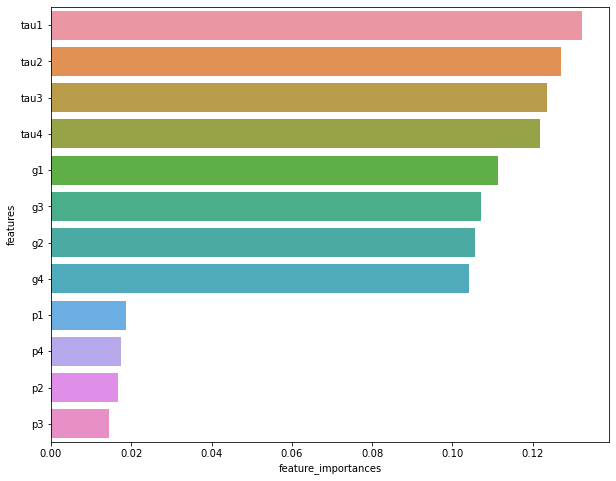

In [38]:
plot_importances(x_train.columns, xgboost.feature_importances_)